In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install mne


# **The Dataset**

In [ ]:
from glob import glob
import os
import mne
import numpy as np
import pandas
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import re

In [ ]:
ASD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/ASD/*.fif')
ADHD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/ADHD/*.fif')
test_ASD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/test_ASD/*.fif')
test_ADHD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/test_ADHD/*.fif')
print(len(ASD_file_path), len(ADHD_file_path))
print(len(test_ASD_file_path), len(test_ADHD_file_path))

30 26
2 5


In [ ]:
def subj_id_finder(file_path):
  pattern = r'(\w+)/(\d+)_(\d+)\.fif'
  match = re.search(pattern, file_path)
  disorder = match.group(1)
  subj_id=int(match.group(2))
  if disorder == 'ADHD':
    subj_id+=16
  return subj_id

In [ ]:
from scipy.signal import hann
import matplotlib.pyplot as plt
def sliding_window(file_path, l_freq=1.0, h_freq=30.0, decim_factor=1,test=False):

    #subj_id = subj_id_finder(file_path)
    raw = mne.io.read_raw_fif(file_path, preload=True)
    raw.filter(l_freq=0.3,h_freq=30)

    data = raw.get_data()

    window_size = 1 * int(raw.info['sfreq'])#250samples
    stride = window_size// 2

    windows = []
    for i in range(0, data.shape[1] - window_size + 1, stride):
        window_data = data[:, i:i+window_size]
        # Apply a low-pass anti-aliasing filter to avoid aliasing
        #anti_alias_data = mne.filter.filter_data(window_data, sfreq=raw.info['sfreq'],  l_freq= 40 , h_freq=None,)
        hann_window = hann(window_size, sym=False)
        window_data = window_data*hann_window
        # Decimate the signal
        decimated_data = mne.filter.resample(window_data, down=1.25, npad='auto')
        windows.append(decimated_data)
        #if not test:
          #group_list.append(subj_id)


    arr = np.array(windows)
    if len(arr)!=0:
      return arr

In [ ]:
test_ADHD_file_path[1]

'/content/gdrive/My Drive/MAIN PROJECT/ICCONS/test1_ADHD/Copy of 2_2.fif'

In [ ]:
%%capture
group_list=[]
ASD_epochs_arr = [sliding_window(i) for i in ASD_file_path ]
ADHD_epochs_arr = [sliding_window(i) for i in ADHD_file_path]
test_ASD_epochs_arr = [sliding_window(i,test=True) for i in test_ASD_file_path]
test_ADHD_epochs_arr = [sliding_window(i,test=True) for i in test_ADHD_file_path]# all test subjects subjects segment is mixed here

In [ ]:
%%capture
#for subject wise testing #major voting
test_ADHD1 = np.array(sliding_window(test_ADHD_file_path[0],test=True))
test_ADHD2 = np.array(sliding_window(test_ADHD_file_path[1],test=True))
test_ADHD3 = np.array(sliding_window(test_ADHD_file_path[2],test=True))

test_ASD1 = np.array(sliding_window(test_ASD_file_path[0],test=True))
test_ASD2 = np.array(sliding_window(test_ASD_file_path[1],test=True))
test_ASD3 = np.array(sliding_window(test_ASD_file_path[2],test=True))

In [ ]:
#subject_test_data
test_ADHD1=np.moveaxis(test_ADHD1,1,2)#reshaping so that channel comes last
test_ADHD2=np.moveaxis(test_ADHD2,1,2)
test_ADHD3=np.moveaxis(test_ADHD3,1,2)
test_ASD1=np.moveaxis(test_ASD1,1,2)
test_ASD2=np.moveaxis(test_ASD2,1,2)
test_ASD3=np.moveaxis(test_ASD3,1,2)
print(test_ADHD1.shape)

(2457, 200, 21)


In [ ]:
ASD_epochs_arr[1].shape,len(ASD_epochs_arr)

((3195, 21, 200), 30)

In [ ]:
ASD_epochs_labels = [len(i)*[0] for i in ASD_epochs_arr.copy()]
ADHD_epochs_labels = [len(i)*[1] for i in ADHD_epochs_arr.copy()]
test_ASD_epochs_labels = [len(i)*[0] for i in test_ASD_epochs_arr.copy()]
test_ADHD_epochs_labels = [len(i)*[1] for i in test_ADHD_epochs_arr.copy()]
len(ASD_epochs_labels),len(ADHD_epochs_labels)

(30, 26)

In [ ]:
data_list = ASD_epochs_arr.copy()+ADHD_epochs_arr.copy()
label_list = ASD_epochs_labels+ADHD_epochs_labels
test_data_list = test_ASD_epochs_arr.copy()+test_ADHD_epochs_arr.copy()
test_label_list = test_ASD_epochs_labels+test_ADHD_epochs_labels

In [ ]:
# #free ram
# ADHD_epochs_arr=0
# ASD_epochs_arr=0
# test_ADHD_epochs_arr=0
# test_ASD_epochs_arr=0

In [ ]:
print(len(data_list))
len(group_list),len(label_list)

56


(72676, 56)

In [ ]:
train_features = np.vstack(data_list)
data_list=0
test_features = np.vstack(test_data_list)
test_data_list=0
label_arr = np.hstack(label_list)
label_list=0
test_labels = np.hstack(test_label_list)
test_label_list=0
group_arr =np.hstack(group_list)
#group_list=0

In [ ]:
group_arr.shape,train_features.shape,label_arr.shape

((72676,), (72676, 21, 200), (72676,))

In [ ]:
group_arr

array([ 1,  1,  1, ..., 31, 31, 31])

In [ ]:
test_features = np.moveaxis(test_features,1,2)
test_features.shape
train_features = np.moveaxis(train_features,1,2)
train_features.shape

(72676, 200, 21)

In [ ]:
# #free ram
# data_list=0
# test_data_list=0
# label_list=0
# test_label_list=0

In [ ]:
# train_labels = label_arr.copy()

In [ ]:
# train_labels

array([0, 0, 0, ..., 1, 1, 1])

# **MODEL**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
scaler =  StandardScaler()
#normalizing
train_features=scaler.fit_transform(train_features.reshape(-1,\
                    train_features.shape[-1])).reshape(train_features.shape)

test_features=scaler.fit_transform(test_features.reshape(-1,\
                    test_features.shape[-1])).reshape(test_features.shape)


In [ ]:
#testing subject wise
test_ADHD1=scaler.fit_transform(test_ADHD1.reshape(-1,\
                    test_ADHD1.shape[-1])).reshape(test_ADHD1.shape)
test_ADHD2=scaler.fit_transform(test_ADHD2.reshape(-1,\
                    test_ADHD2.shape[-1])).reshape(test_ADHD2.shape)
test_ADHD3=scaler.fit_transform(test_ADHD3.reshape(-1,\
                    test_ADHD3.shape[-1])).reshape(test_ADHD3.shape)
test_ASD1=scaler.fit_transform(test_ASD1.reshape(-1,\
                    test_ASD1.shape[-1])).reshape(test_ASD1.shape)
test_ASD2=scaler.fit_transform(test_ASD2.reshape(-1,\
                    test_ASD2.shape[-1])).reshape(test_ASD2.shape)
test_ASD3=scaler.fit_transform(test_ASD3.reshape(-1,\
                    test_ASD3.shape[-1])).reshape(test_ASD3.shape)


In [ ]:
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D,ReLU,MaxPooling1D,InputLayer,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import keras.backend as K
K.clear_session()
from keras import regularizers

## **MODELS**

In [ ]:
#model 1 #based on paper1
clear_session()
model=Sequential()
model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(200,21)))#1
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool1D(pool_size=2,strides=2))#2
model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
model.add(LeakyReLU())
model.add(MaxPool1D(pool_size=2,strides=2))#4
model.add(Dropout(0.5))
model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
model.add(LeakyReLU())
model.add(AveragePooling1D(pool_size=2,strides=2))#6
model.add(Dropout(0.5))
model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
model.add(LeakyReLU())
model.add(AveragePooling1D(pool_size=2,strides=2))#8
model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())#10
model.add(Dense(1,activation='sigmoid'))#11

model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])

Chronet

In [ ]:
#model 2 # paper 2
#complex #overfitting
def block(input):
  conv1 = Conv1D(filters=32,kernel_size=2,strides=2,activation='relu',padding='causal')(input)
  conv2 = Conv1D(filters=32,kernel_size=4,strides=2,activation='relu',padding='causal')(input)
  conv3 = Conv1D(filters=32,kernel_size=8,strides=2,activation='relu',padding='causal')(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

input = Input(shape=(200, 21))
block1 = block(input)
#block1.shape
block2 = block(block1)
block3 = block(block2)
#block3.shape
gru1 = GRU(units=32,return_sequences=True)(block3)
gru2 = GRU(units=32,return_sequences=True)(gru1)
gru_out = concatenate([gru1,gru2],axis=2)

gru3 = GRU(units=32,return_sequences=True)(gru_out)
gru_out = concatenate([gru1,gru2,gru3],axis=2)
#gru_out.shape
gru4 = GRU(units=32)(gru_out)
out2 = Dense(16,activation='relu')(gru4)
out = Dense(1,activation='sigmoid')(out2)
model = Model(inputs=input,outputs=out)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
#modelv3
model = Sequential()
model.add(InputLayer(input_shape=(200, 21)))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
#history = model.fit(train_features,train_labels,epochs=50,batch_size=32,validation_data=(test_features,test_labels))

In [ ]:
#modelv4
model = Sequential()
model.add(InputLayer(input_shape=(200, 21)))

model.add(Conv1D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# **TRAINING**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',
    patience=20,
    min_delta=0.001,
    mode='max',restore_best_weights=True)

In [ ]:
history = model.fit(train_features,train_labels,
                    epochs=70,batch_size=32,
                    callbacks=[early_stopping],
                    shuffle=True,
                    validation_data=(test_features,test_labels))

In [ ]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)

420/420 [==============================] - 3s 6ms/step - loss: 0.8869 - accuracy: 0.7305
Test accuracy: 0.7304826974868774


# **Ploting and Saving**

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("model_78v4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_78v4.h5")

## **LOADING Saved Model**

In [ ]:
from keras.initializers import glorot_uniform
from tensorflow.keras.models import model_from_json
#Reading the model from JSON file
with open('model_78v4.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture
model_j = model_from_json(json_savedModel)
model_j.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 196, 32)           3392      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 98, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 94, 64)            10304     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 47, 64)           0         
 1D)                                                             
                                                      

In [ ]:
model_j.load_weights('model_78v4.h5')

In [ ]:
#Compiling the model
model_j.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

420/420 [==============================] - 3s 6ms/step


<ipython-input-51-60096e79f1c1>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-51-60096e79f1c1>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


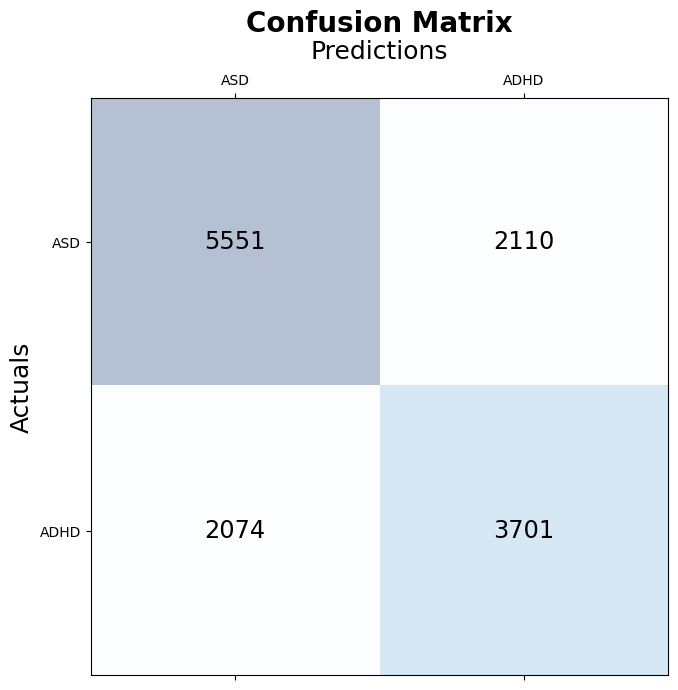

In [ ]:
#SEGMENTATION WISE Confusion Matrix
from sklearn.metrics import confusion_matrix
#
# Get the predictions
#
y_pred = model.predict(test_features)
y_pred =(y_pred > 0.5).astype(int)
labels = ['ASD', 'ADHD']
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.xaxis.set_label_coords(0.5, 1.1)

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)

plt.title('Confusion Matrix', fontsize=20,fontweight="bold")
plt.show()

In [ ]:
# Extract the true positive, true negative, false positive, and false negative values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Print the true positive, true negative, false positive, and false negative values
print("True Positive (TP): ", tp)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("False Negative (FN): ", fn)

# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate precision
precision = tp / (tp + fp)

# Calculate recall
recall = tp / (tp + fn)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the formulas for accuracy, precision, recall, and F1-score
print("\n\nFormulas:")
print("Accuracy: (TP + TN) / (TP + TN + FP + FN)")
print("Precision: TP / (TP + FP)")
print("Recall: TP / (TP + FN)")
print("F1-score: 2 * (Precision * Recall) / (Precision + Recall)")

# Print the accuracy, precision, recall, and F1-score
print("\n\nMetrics:")
print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1-score: ", round(f1_score, 2))

True Positive (TP):  4055
True Negative (TN):  6503
False Positive (FP):  1158
False Negative (FN):  1720


Formulas:
Accuracy: (TP + TN) / (TP + TN + FP + FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
F1-score: 2 * (Precision * Recall) / (Precision + Recall)


Metrics:
Accuracy:  0.79
Precision:  0.78
Recall:  0.7
F1-score:  0.74


In [ ]:
y1=np.average(model_j.predict(test_ADHD1))
# y1 =(y1 > 0.5).astype(int)
# print(np.average(y1))
y2=np.average(model_j.predict(test_ADHD2))
y3=np.average(model_j.predict(test_ADHD3))
y4=np.average(model_j.predict(test_ASD1))
y5=np.average(model_j.predict(test_ASD2))
y6=np.average(model_j.predict(test_ASD3))
actuals=[1,1,1,0,0,0]#adhd =>1 and asd=>0

116/116 [==============================] - 1s 5ms/step


In [ ]:
y6

0.069319755

In [ ]:
y_pred=[y6,y5,y2,y1]
y_pred=[1 if x > 0.5 else 0 for x in y_pred]
y_pred

[0, 0, 1, 0]

<ipython-input-102-3162ef197b4e>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-102-3162ef197b4e>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


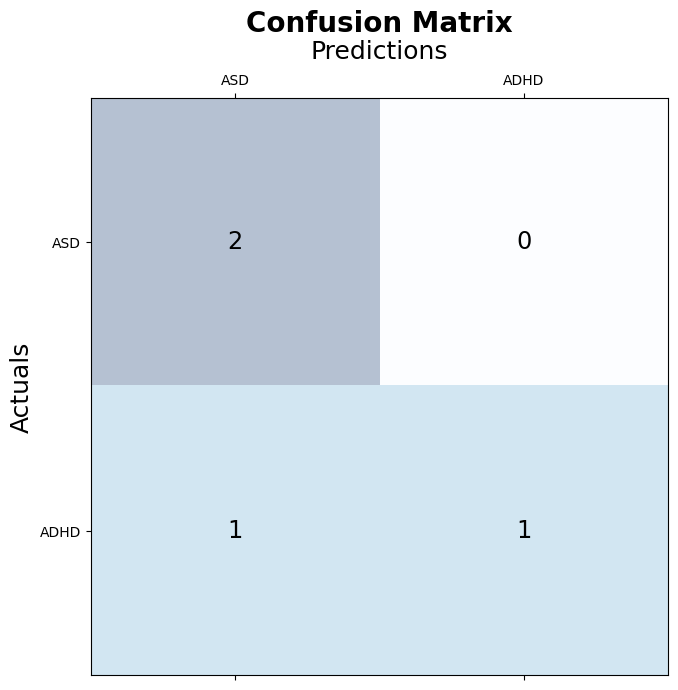

In [ ]:
from sklearn.metrics import confusion_matrix
#
# SUBJECT WISE PREDICTION
#

labels = ['ASD', 'ADHD']
# Calculate the confusion matrix
#
conf_matrix2 = confusion_matrix(y_true=actual, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix2, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix2.shape[0]):
    for j in range(conf_matrix2.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix2[i, j], va='center', ha='center', size='xx-large')

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.xaxis.set_label_coords(0.5, 1.1)

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)

plt.title('Confusion Matrix', fontsize=20,fontweight="bold")
plt.show()